In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import linkage, dendrogram

from sentence_transformers import SentenceTransformer

In [7]:
df = pd.read_csv('Reviews.csv')  # replace with your path
print(df.head())
print(f"Total reviews: {len(df)}")

# Select useful columns
df = df[['Text', 'Score']]
df = df.dropna(subset=['Text'])

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [8]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)  # remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text)  # remove extra spaces
    return text.strip()

df['CleanText'] = df['Text'].apply(clean_text)


In [9]:
import numpy as np
from sentence_transformers import SentenceTransformer

print("Generating sentence embeddings...")
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
embeddings = model.encode(df['CleanText'].tolist(), show_progress_bar=True)

# Print shape for confirmation
print(f"Embeddings shape: {embeddings.shape}")

# Save embeddings as .npz file
np.savez_compressed("embeddings.npz", embeddings=embeddings)
print("✅ Embeddings saved successfully as 'embeddings.npz'")


Generating sentence embeddings...


Batches: 100%|██████████| 17765/17765 [05:40<00:00, 52.12it/s] 


Embeddings shape: (568454, 384)
✅ Embeddings saved successfully as 'embeddings.npz'


✅ Loaded embeddings of shape: (568454, 384)

--- K-Means Cluster Counts ---
KMeans_Cluster
3    170999
0    159601
1     85913
2     79863
4     72078
Name: count, dtype: int64

Cluster 0 Sample Reviews:
['Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'
 'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.']

Cluster 1 Sample Reviews:
['If you are looking for the secret ingredient in Robitussin

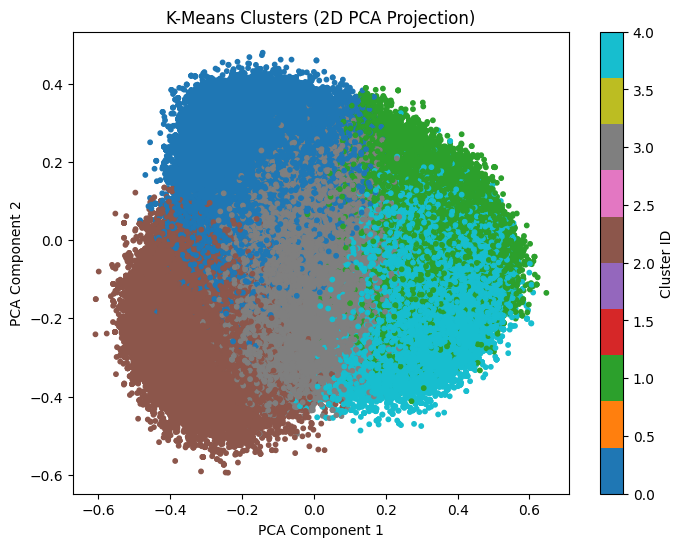

In [3]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ============================================================
# Load Data & Embeddings
# ============================================================
df = pd.read_csv('Reviews.csv')[['Text', 'Score']].dropna(subset=['Text'])
data = np.load('embeddings.npz')
embeddings = data['embeddings']

print(f"✅ Loaded embeddings of shape: {embeddings.shape}")

# ============================================================
# K-MEANS CLUSTERING
# ============================================================
num_clusters = 5  # change as needed

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(embeddings)

print("\n--- K-Means Cluster Counts ---")
print(df['KMeans_Cluster'].value_counts())

# Show example reviews from each cluster
for i in range(num_clusters):
    print(f"\nCluster {i} Sample Reviews:")
    print(df[df['KMeans_Cluster'] == i]['Text'].head(2).values)

# ============================================================
# Visualize clusters using PCA (2D)
# ============================================================
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=df['KMeans_Cluster'], cmap='tab10', s=10)
plt.title('K-Means Clusters (2D PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster ID')
plt.show()


✅ Using random sample of 5000 reviews for Hierarchical Clustering
Embeddings subset shape: (5000, 384)


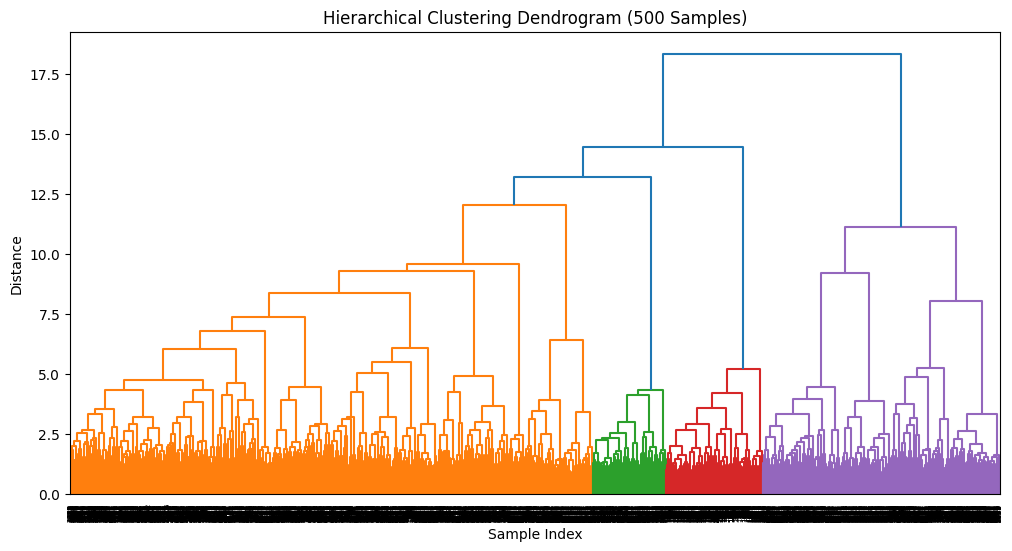


--- Hierarchical Cluster Counts ---
HierCluster
1    2441
0    1275
2     520
3     393
4     371
Name: count, dtype: int64

Hierarchical Cluster 0 Sample Reviews:
['I\'ve tried several brands and flavors of ground coffee from Amazon, and this is by far the.best.coffee.I\'ve.had. I decided to write a review because last weekend my husband made me a latte, and it was yummy. I asked for a second one, and what he gave me was not what I had the first time. I asked him what was different, and he told me he used a different brand and flavor. He was really surprised that I could tell. The one that I LOVED was the Lavazza Crema e Gusto. Wow. What a difference. It\'s smooth and full bodied - okay, I\'m full of crap. I have no idea what "full bodied" is other than a fat chick. But I can tell you this -- this coffee is tasty and you will not regret buying it.<br /><br />I bought it in January because there was a deal going on - $12 for 4 bricks. But here I am willing to pay $15 for 4 bricks (S&S

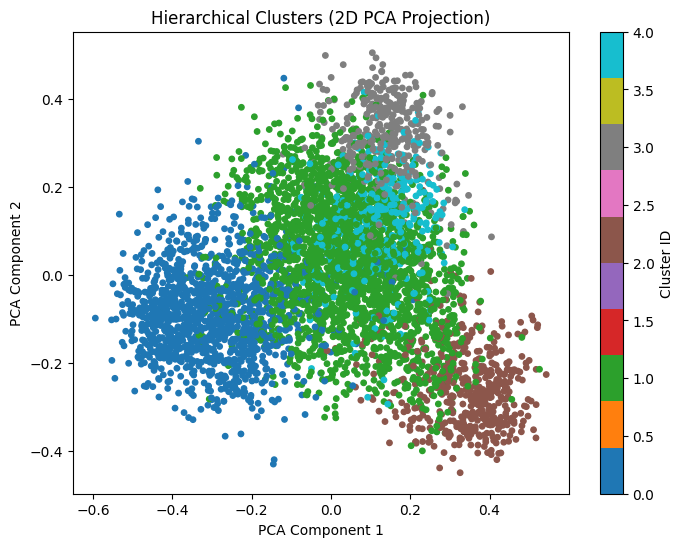


✅ Hierarchical clustering complete.


In [6]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# ============================================================
# Load and Sample Data
# ============================================================
df = pd.read_csv('Reviews.csv')[['Text', 'Score']].dropna(subset=['Text'])
data = np.load('embeddings.npz')
embeddings = data['embeddings']

# Randomly sample 500 reviews
sample_size = 5000
df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
embed_sample = embeddings[df_sample.index]

print(f"✅ Using random sample of {sample_size} reviews for Hierarchical Clustering")
print(f"Embeddings subset shape: {embed_sample.shape}")

# ============================================================
# DENDROGRAM (visualize merge distances)
# ============================================================
linked = linkage(embed_sample, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Hierarchical Clustering Dendrogram (500 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# ============================================================
# AGGLOMERATIVE CLUSTERING
# ============================================================
n_clusters = 5
hier_cluster = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
df_sample['HierCluster'] = hier_cluster.fit_predict(embed_sample)

print("\n--- Hierarchical Cluster Counts ---")
print(df_sample['HierCluster'].value_counts())

# Example reviews from each cluster
for i in range(n_clusters):
    print(f"\nHierarchical Cluster {i} Sample Reviews:")
    print(df_sample[df_sample['HierCluster'] == i]['Text'].head(2).values)

# ============================================================
# 2D Visualization using PCA
# ============================================================
pca = PCA(n_components=2)
reduced = pca.fit_transform(embed_sample)

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1],
            c=df_sample['HierCluster'], cmap='tab10', s=15)
plt.title('Hierarchical Clusters (2D PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster ID')
plt.show()

print("\n✅ Hierarchical clustering complete.")


✅ Using random sample of 500 reviews for clustering
Embeddings shape: (500, 384)

--- K-Means Cluster Counts ---
Cluster
4    178
3    118
1     82
0     75
2     47
Name: count, dtype: int64

--- Cluster Evaluation Metrics ---
1️⃣ Silhouette Score (intrinsic): 0.0604
2️⃣ Davies–Bouldin Index (intrinsic): 3.6088
3️⃣ Adjusted Rand Index (extrinsic): -0.0073
4️⃣ Normalized Mutual Information (extrinsic): 0.0085


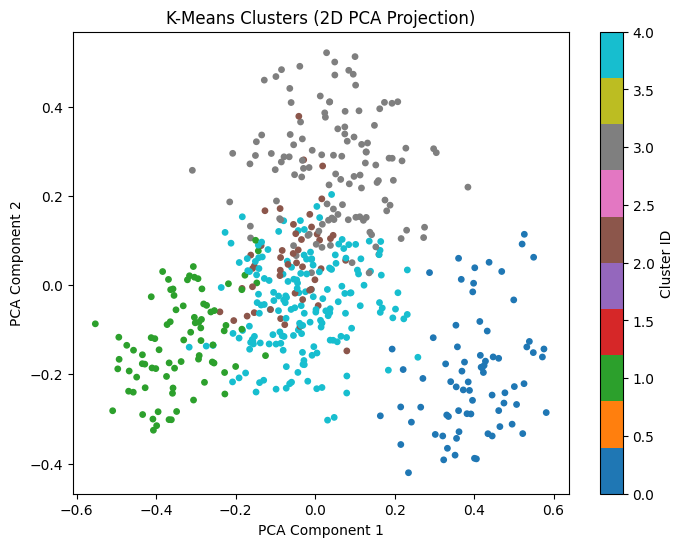


✅ Clustering and evaluation complete.


In [7]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ============================================================
# Load Dataset and Embeddings
# ============================================================
df = pd.read_csv('Reviews.csv')[['Text', 'Score']].dropna(subset=['Text'])
data = np.load('embeddings.npz')
embeddings = data['embeddings']

# Randomly select 500 samples
sample_size = 500
df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
embed_sample = embeddings[df_sample.index]

print(f"✅ Using random sample of {sample_size} reviews for clustering")
print(f"Embeddings shape: {embed_sample.shape}")

# ============================================================
# K-MEANS CLUSTERING
# ============================================================
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embed_sample)
df_sample['Cluster'] = cluster_labels

print("\n--- K-Means Cluster Counts ---")
print(df_sample['Cluster'].value_counts())

# ============================================================
# CLUSTER EVALUATION
# ============================================================

# --- Intrinsic metrics ---
silhouette = silhouette_score(embed_sample, cluster_labels)
db_index = davies_bouldin_score(embed_sample, cluster_labels)

# --- Extrinsic metrics (using Score as pseudo “true” labels) ---
true_labels = df_sample['Score'].astype(int)
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print("\n--- Cluster Evaluation Metrics ---")
print(f"1️⃣ Silhouette Score (intrinsic): {silhouette:.4f}")
print(f"2️⃣ Davies–Bouldin Index (intrinsic): {db_index:.4f}")
print(f"3️⃣ Adjusted Rand Index (extrinsic): {ari:.4f}")
print(f"4️⃣ Normalized Mutual Information (extrinsic): {nmi:.4f}")

# ============================================================
# VISUALIZE CLUSTERS IN 2D (PCA)
# ============================================================
pca = PCA(n_components=2)
reduced = pca.fit_transform(embed_sample)

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=cluster_labels, cmap='tab10', s=15)
plt.title('K-Means Clusters (2D PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster ID')
plt.show()

print("\n✅ Clustering and evaluation complete.")
